In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import os
#os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [2]:
train_dir = r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\hmt_dataset\HMT_train' #you should change to your directory
test_dir = r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\hmt_dataset\HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [3]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [126]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

# Training

In [4]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [5]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [6]:
model=load_model(r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\models\HMT.h5')

In [121]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'log/train'

Text(0.5, 1.0, 'Training progress: Accuracy')

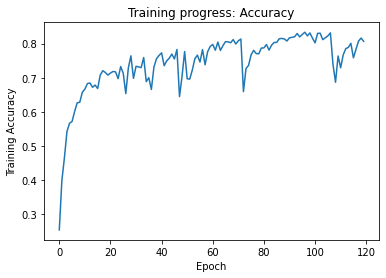

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

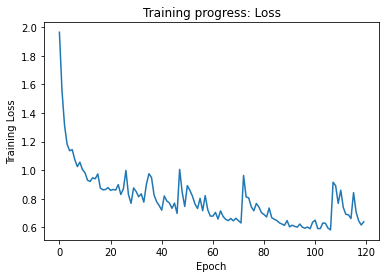

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

In [7]:
# 3b test accuracy

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate_generator(generator=test_generator)
print("test loss, test acc:", results)


Evaluate on test data


C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test loss, test acc: [0.5553839802742004, 0.8346773982048035]


In [8]:
# C Class-wise accuracy
class_data = [[] for _ in range(8)]
for j in range(len(test_generator)):
    test_data = test_generator[j][0]
    test_labels = test_generator[j][1]
    for i, data in enumerate(test_data):
        class_data[np.argmax(test_labels[i])].append(data)

for i, data in enumerate(class_data):
    class_data[i] = np.array(data)

class_acc = []

for i in range(8):
    label = np.zeros(8)
    label[i] = 1
    labels = [label for _ in range(len(class_data[i]))]
    labels = np.array(labels)
    results = model.evaluate(class_data[i], labels, batch_size=32)
    class_acc.append(results[1])
class_acc

2/2 [==============================] - 0s 11ms/step - loss: 0.2351 - accuracy: 1.0000


[0.8548387289047241,
 0.7580645084381104,
 0.774193525314331,
 0.8548387289047241,
 0.6612903475761414,
 0.8225806355476379,
 0.9516128897666931,
 1.0]

In [179]:
# D ROC and AUC curves for each class

from sklearn import metrics

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    labels = np.zeros(496)
    for k, label in enumerate(test_labels):
        if label == i:
            labels[k] = 1
    pred = model.predict_generator(test_generator)
    pred_score = np.zeros(496)
    for j,score in enumerate(pred):
        pred_score[j] = score[i]
    fpr[i], tpr[i], _ = metrics.roc_curve(labels, np.array(pred_score))
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2035: 

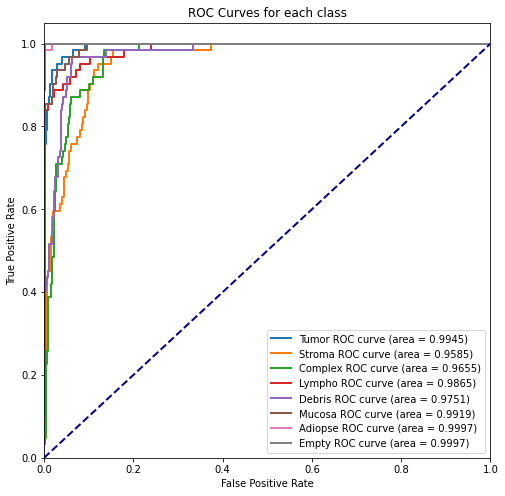

In [181]:
plt.figure(figsize=(8,8))
lw = 2

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

for i in range(8):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="%s ROC curve (area = %0.4f)" % (class_names[i], roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for each class")
plt.legend(loc="lower right")
plt.show()

C:\Users\Stephanie\anaconda3\envs\ece1512\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Text(0.5, 1.0, 'Normalized Confusion Matrix')

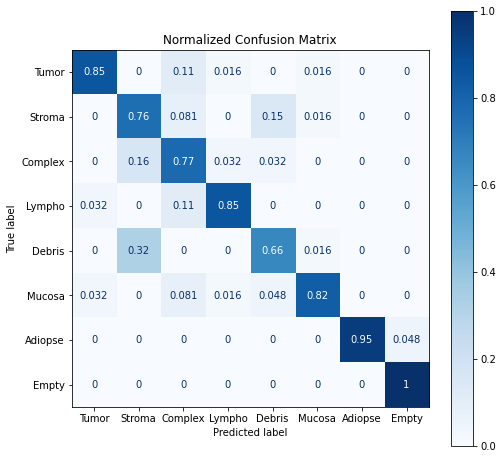

In [133]:
# E Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
pred = model.predict_generator(test_generator)
pred_classes = np.argmax(pred,axis=-1)

test_labels = []
for j in range(len(test_generator)):
    labels = test_generator[j][1]
    for i, data in enumerate(labels):
        test_labels.append(np.argmax(data))

title = "Normalized Confusion Matrix"

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

fig, ax = plt.subplots(figsize=(8,8))

disp = ConfusionMatrixDisplay.from_predictions(
        test_labels,
        pred_classes,
        display_labels=class_names,
        cmap=plt.cm.Blues, ax=ax,
        normalize='true',
    )
disp.ax_.set_title(title)

In [135]:
# F Precision, Recall, and F-1
from sklearn.metrics import classification_report
report = classification_report(test_labels,pred_classes,output_dict=True)
df = pd.DataFrame(report).transpose()
df.pop('support')
df = pd.concat([df[0:8] , df[10:]])
df

,precision,recall,f1-score
0,0.929825,0.854839,0.890756
1,0.610390,0.758065,0.676259
2,0.666667,0.774194,0.716418
3,0.929825,0.854839,0.890756
4,0.745455,0.661290,0.700855
5,0.944444,0.822581,0.879310
6,1.000000,0.951613,0.975207
7,0.953846,1.000000,0.976378
weighted avg,0.847556,0.834677,0.838242


# Explanation

Load the explaier library

In [8]:
from xai_utils import *

Load a batch of images

In [9]:
test_generator.reset()

In [22]:
image_batch,label_batch=test_generator.next()

Classes:

In [11]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [23]:
index=2

In [24]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9181885


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [14]:
layers=[['conv2d_3']]

In [25]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: total: 62.5 ms
Wall time: 63 ms


## LIME

In [34]:
%%time

from lime import *

label = np.argmax(label_batch[index])
img = image_batch[index]
explanation_map_LIME = LIME_img(img, model, label, num_perturb=400, kernel_size=3,max_dist=200, ratio=0.2, kernel_w=0.25, num_feats=12)

CPU times: total: 15.2 s
Wall time: 12.1 s


## Plot the results

Text(0.5, 1.0, 'Explanation map (LIME)')

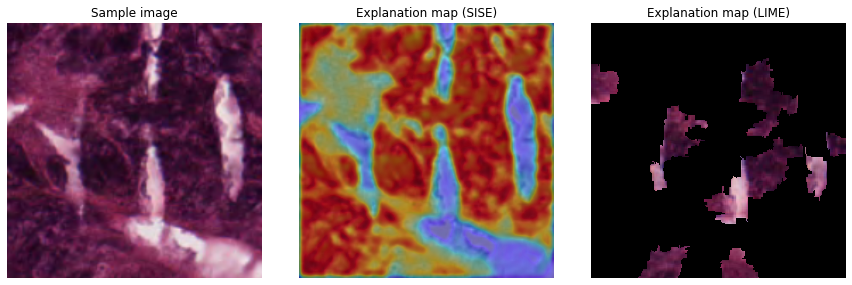

In [35]:
#@title Plot the results

plt.figure(figsize=(16,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
skimage.io.imshow(explanation_map_LIME, cmap='jet')
plt.axis('off')
plt.title('Explanation map (LIME)')


## Quantitative evaluation of the explanation algorithm

In [36]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [37]:
test_generator.reset()
drop_rate = 0.
increase = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate_add, increase_add= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0:2]
        drop_rate += drop_rate_add
        increase += increase_add
drop_rate /= (15*32)
increase /= (15*32)

In [38]:
print(drop_rate)
print(increase)

0.5977560567925025
0.17916666666666667
